In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat

In [2]:
os.getcwd()

'C:\\Users\\JunHyuk'

In [3]:
data=loadmat('ex4data1.mat')
X,y=data['X'],data['y'].ravel()
y[y==10]=0
m=y.size

In [4]:
def displayData(X,example_width=None, figsize=(6,6)):
    if X.ndim==2:
        m,n = X.shape
    elif X.ndim==1:
        n=X.size
        m=1
        X=X[None]
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')
    
    example_width=example_width or int(np.round(np.sqrt(n)))
    example_height=n/example_width
    
    display_rows=int(np.floor(np.sqrt(m)))
    display_cols=int(np.ceil(m/display_rows))
    
    fig,ax_array=pyplot.subplots(display_rows,display_cols,figsize=figsize)
    fig.subplots_adjust(wspace=0.025,hspace=0.025)
    
    ax_array=[ax_array] if m==1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width,example_width,order='F'),cmap='Greys',extent=[0,1,0,1])
        ax.axis('off')

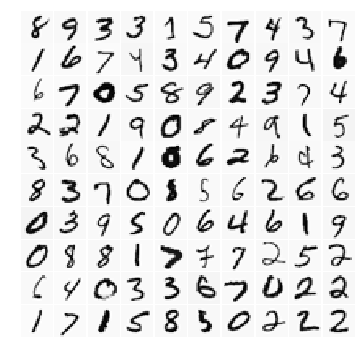

In [5]:
rand_indices=np.random.choice(m,100,replace=False)
sel=X[rand_indices,:]
displayData(sel)

In [6]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [7]:
input_layer_size=400
hidden_layer_size=25
num_labels=10
weights=loadmat('ex4weights.mat')
theta1,theta2=weights['Theta1'],weights['Theta2']
theta2=np.roll(theta2,1,axis=0)
nn_params=np.concatenate([theta1.ravel(),theta2.ravel()])

In [8]:
def predict(theta1,theta2,X):
    if X.ndim == 1:
        X = X[None]
    
    m = X.shape[0]
    num_labels = theta2.shape[0]
    p = np.zeros(m)
    
    X=np.concatenate([np.ones((m,1)),X],axis=1)
    z2=theta1.dot(X.T)
    a2=sigmoid(z2)
    a2=np.concatenate([np.ones((1,a2.shape[1])),a2],axis=0)
    
    z3=theta2.dot(a2)
    a3=sigmoid(z3)
    
    p=np.argmax(a3,axis=0)
    
    return a2, a3, p
    

In [9]:
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_=0.0):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],(hidden_layer_size,(input_layer_size+1)))
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],(num_labels,(hidden_layer_size+1)))
    m = y.size
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    a1=np.concatenate([np.ones((5000,1)),X],axis=1)
    
    a2, a3, p = predict(theta1, theta2, X)
    
    onehot = np.zeros((10,5000))
    for c in range(5000):
        onehot[y[c],c] = 1
    y = onehot
    
    for i in range(5000):
        left = -y[:,i].T.dot(np.log(a3[:,i]))
        right = -(1-y[:,i]).T.dot(np.log(1-a3[:,i]))
        J = J + left + right
    
    no0theta2 = theta2[:,1:]
    no0theta1 = theta1[:,1:]
    tss2 = np.sum(no0theta2**2)
    tss1 = np.sum(no0theta1**2) 
    tss = tss2 + tss1
    
    J=1/m*J+lambda_/(2*m)*tss
    
    delta3 = y - a3
    delta2 = theta2[:,1:].T.dot(delta3) * a2[1:,:]*(1-a2[1:,:])
    
    tri2 = delta3.dot(a2.T)
    tri1 = delta2.dot(a1)
    
    temp2 = theta2
    temp2[:,0] = 0
    temp1 = theta1
    temp1[:,0] = 0
    
    theta2_grad = 1/m*tri2 + lambda_*temp2
    theta1_grad = 1/m*tri1 + lambda_*temp1
    
    
    grad = np.concatenate([theta1_grad.ravel(), theta2_grad.ravel()])
    
    return J, grad

In [10]:
lambda_=1
J,grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
J

0.3837698590909233

In [11]:
def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [12]:
def randInitializeWeights(L_out, L_in, epsilon_init=0.0001):
    W = np.random.rand(L_out, L_in+1)*2*epsilon_init - epsilon_init
    return W

In [13]:
initial_theta1 = randInitializeWeights(hidden_layer_size,input_layer_size)
initial_theta2 = randInitializeWeights(num_labels, hidden_layer_size)
initial_nn_params = np.concatenate([initial_theta1.ravel(),initial_theta2.ravel()],axis=0)

In [14]:
def computeJ(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],(hidden_layer_size,(input_layer_size+1)))
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],(num_labels,(hidden_layer_size+1)))
    m = y.size
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    a1=np.concatenate([np.ones((m,1)),X],axis=1)
    
    a2, a3, p = predict(theta1, theta2, X)
    
    onehot = np.zeros((num_labels,m))
    for c in range(m):
        onehot[y[c],c] = 1
    y = onehot
    
    for i in range(m):
        left = -y[:,i].T.dot(np.log(a3[:,i]))
        right = -(1-y[:,i]).T.dot(np.log(1-a3[:,i]))
        J = J + left + right
    
    no0theta2 = theta2[:,1:]
    no0theta1 = theta1[:,1:]
    tss2 = np.sum(no0theta2**2)
    tss1 = np.sum(no0theta1**2) 
    tss = tss2 + tss1
    
    J=1/m*J+lambda_/(2*m)*tss
    return J


In [15]:
def computeGradApprox(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,e):
    plus = np.zeros(hidden_layer_size*(input_layer_size+1)+num_labels*(hidden_layer_size+1))
    minus = np.zeros(hidden_layer_size*(input_layer_size+1)+num_labels*(hidden_layer_size+1))
    
    for i in range(hidden_layer_size*(input_layer_size+1)+num_labels*(hidden_layer_size+1)):
        temp = nn_params
        temp[i] = temp[i]+e
        plus[i] = computeJ(temp,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)
        temp[i] = temp[i]-2*e
        minus[i] = computeJ(temp,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)
    
    approx = (plus-minus)/(2*e)
    return approx

In [16]:
lambda_=3
J,grad = nnCostFunction(initial_nn_params,input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
J

6.931367016538795

In [17]:
e=0.0001
#approx = computeGradApprox(initial_nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,e)
diff = np.linalg.norm(approx-grad)/np.linalg(approx+grad)

NameError: name 'approx' is not defined

In [ ]:
np.max(diff)